In [1]:
import os
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
STATE_LABELS = {
    "PostureDatastoreController_FDTask_torque": "RL+QP (FDTask)",
    "PostureDatastoreController_FDTask_torque_extForce": "FDTask_extForce",
    "PostureDatastoreController_PureRL": "RL",
    "PostureDatastoreController_TorqueTask_torque": "RL+QP (TorqueTask)",
    "PostureDatastoreController_TorqueTask_torque_extForce": "TorqueTask_extForce",
}

STATE_COLORS = {
    "PostureDatastoreController_FDTask_torque": "deepskyblue",
    "PostureDatastoreController_FDTask_torque_extForce": "royalblue",
    "PostureDatastoreController_PureRL": "darkgrey",
    "PostureDatastoreController_TorqueTask_torque": "coral",
    "PostureDatastoreController_TorqueTask_torque_extForce": "darkred",
}

JOINT_LIMIT_UPPER = 2.45
JOINT_LIMIT_LOWER = -2.45
JOINT_LIMIT_SECURITY_DISTANCE = (JOINT_LIMIT_UPPER - JOINT_LIMIT_LOWER)*0.01  # 1% of range


In [3]:
def detect_segments(df: pd.DataFrame, start_col: str, end_col: str, state_col: str, inverse_transition_start: bool = False, inverse_transition_end: bool = False, dt = 0.001, max_end_time = None, shift_start_time = None) -> List[Tuple[int,int]]:
    """Detect segments as index ranges (inclusive start, exclusive end+1) where
    start is the index where start_col transitions 1 -> 0 and end is the first
    index after start where end_col transitions 1 -> 0.

    Returns a list of (start_idx, end_idx) pairs where both are integer row indices
    and the slice to use is df.iloc[start_idx:end_idx+1].
    """
    s = df[start_col].fillna(0).astype(int)
    e = df[end_col].fillna(0).astype(int)

    if(inverse_transition_start):
        # Detect 0 -> 1 transitions: previous ==0 and current ==1
        s_trans = (s.shift(1) == 0) & (s == 1)
    else:
        # Detect 1 -> 0 transitions: previous ==1 and current ==0
        s_trans = (s.shift(1) == 1) & (s == 0)
    

    if(inverse_transition_end):
        # Detect 0 -> 1 transitions: previous ==0 and current ==1
        e_trans = (e.shift(1) == 0) & (e == 1)
    else:
        # Detect 1 -> 0 transitions: previous ==1 and current ==0
        e_trans = (e.shift(1) == 1) & (e == 0)


    start_idxs = list(s_trans[s_trans].index)
    end_idxs = list(e_trans[e_trans].index)

    segments: List[Tuple[int,int]] = []
    max_len = int(max_end_time / dt) if max_end_time is not None else None

    shift_start_time = int(shift_start_time / dt) if shift_start_time is not None else 0

    # Pair each start with the first end index greater than start
    ei = 0
    for si in start_idxs:
        # advance an end pointer until we find end > si
        while ei < len(end_idxs) and end_idxs[ei] <= si:
            ei += 1
        if ei < len(end_idxs):
            end_idx = end_idxs[ei]
            ei += 1
        else:
            # no more end signal → extend until state changes or file ends
            current_state = df.loc[si, state_col]
            after_si = df[state_col].iloc[si:]
            # first index where state changes
            change = after_si[after_si != current_state]
            if not change.empty:
                end_idx = change.index[0] - 1
            else:
                end_idx = len(df) - 1
        
        # truncate if too long
        if max_len is not None and (end_idx - si + 1) > max_len:
            end_idx = si + max_len - 1   
        
        segments.append((si-shift_start_time, end_idx))
    return segments

In [4]:
def icra_style():
    """Apply a compact ICRA-like style for paper figures."""
    rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'DejaVu Sans', 'Arial'],
        'pdf.fonttype': 42,  # ensure editable text in vector pdfs
        'ps.fonttype': 42,
        'font.size': 8,
        'axes.titlesize': 9,
        'axes.labelsize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'axes.linewidth': 0.6,
    })

In [5]:
def plot_comparison(
        df, 
        segments, 
        state_col, 
        dist_col, 
        dt, 
        states_to_compare, 
        out_path, 
        alpha: float = 0.4, 
        add_q_limit: bool = False,
        y_label: str = 'Norm of Target Distance [m]'
    ):
    icra_style()
    fig, ax = plt.subplots(figsize=(3.5, 2.4))

    plotted_states = set()
    for state in states_to_compare:
        for s_idx, e_idx in segments:
            seg_df = df.iloc[s_idx:e_idx+1]
            seg_state = seg_df[state_col].iloc[0]
            if seg_state != state:
                continue
            dist = seg_df[dist_col].to_numpy()
            t = np.arange(len(dist)) * dt
            label = STATE_LABELS.get(state, state)
            
            line, = ax.plot(t, dist, 
                    linewidth=0.6, 
                    alpha=alpha, 
                    color=STATE_COLORS.get(state),
                    linestyle="-.",
                    label=label if state not in plotted_states else None)
            if state not in plotted_states:
                line.set_alpha(1)
            plotted_states.add(state)
    
    if(add_q_limit):
        # Add joint limit reference line
        ax.axhline(y=JOINT_LIMIT_LOWER, color="red", linewidth=0.4, label="Joint limit")
        ax.axhline(y=JOINT_LIMIT_LOWER + JOINT_LIMIT_SECURITY_DISTANCE, color="green", linewidth=0.4, label="Safety margin")

    ax.set_xlabel("Time [s]")
    ax.set_ylabel(y_label)
    ax.grid(True, linestyle=":", linewidth=0.4, alpha=0.6)
    ax.legend(frameon=False)
    
    plt.tight_layout()
    fig.savefig(out_path, dpi=300)

In [ ]:
df = pd.read_csv("collisionExp.csv", sep=';')
df.columns = [c.strip() for c in df.columns]

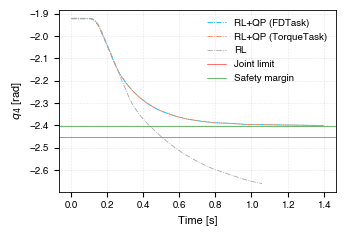

In [7]:
segments = detect_segments(df, 'RLController_convergedToPtTarget', 'RLController_convergedToPtInit', 'Executor_PostureDatastoreController_Collision_Exp', inverse_transition_end=True, max_end_time=1.2, shift_start_time =0.2)
if not segments:
    raise RuntimeError('No segments detected. Check that the boolean columns contain 0->1 transitions as described.')
plot_comparison(df, segments, 'Executor_PostureDatastoreController_Collision_Exp', "qIn_3", dt=0.001, states_to_compare=['PostureDatastoreController_FDTask_torque', 'PostureDatastoreController_TorqueTask_torque', 'PostureDatastoreController_PureRL'], out_path='comparison_collision_notebook.pdf', add_q_limit=True, y_label='$q_{4}$ [rad]')
